In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cortex
import cortex.polyutils
import os
import popeye


from joblib import Parallel, delayed
from numpy import exp, linspace, random
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import scipy
from scipy import stats


Surface database stuff.

In [2]:
subject='02'
left, right = cortex.db.get_surf(subject, 'fiducial')


left_surface = cortex.polyutils.Surface(left[0], left[1])
right_surface = cortex.polyutils.Surface(right[0], right[1])

In [3]:
import dill
def load(filename):
	input_file = open(filename, 'rb')
	obj = dill.load(input_file)
	return obj

Load in the data. This is a big dictionary from my prf model fitting. Take just the left hemisphere for now.

In [4]:
dump_path='/Volumes/BAHAMUT/OUTPUT/FULL'

DATA=load(os.path.join(dump_path,'DICTS','02_prf.pkl'))

In [5]:
sframe=DATA['shortframe']
sframeL=sframe[0:163842]
sframeR=sframe[163842:]

In [6]:
DATA=None

In [9]:
sframeR.head()

,R2,sigma,isigma,ecc,iecc,ang,iang,X,Y,ROI,idx
163842,5.937088,1.587038,0.0,70.424289,0.0,135.157437,0.0,49.660471,-49.934138,0.0,0.0
163843,16.973076,0.064310,0.0,0.658938,0.0,356.764659,0.0,-0.037189,0.657888,0.0,1.0
163844,13.799827,1.123022,0.0,48.908812,0.0,191.008535,0.0,-9.339393,-48.008829,0.0,2.0
163845,23.822198,0.464091,0.0,22.743203,0.0,178.625758,0.0,0.545445,-22.736661,0.0,3.0
163846,53.456980,10.000000,0.0,15.081240,0.0,310.786324,0.0,-11.418776,9.851668,0.0,4.0


Also import the data that the prfs were fit to.

In [16]:
def dill_save(obj,filename):
    with open(filename,'wb') as output:
        dill.dump(obj,output)

In [17]:
#BIGDATAL=load('/Volumes/BAHAMUT/DUMP/BIGLHEM.pkl')
#BIGDATAR=load('/Volumes/BAHAMUT/DUMP/BIGRHEM.pkl')

In [19]:
#LDAT32=BIGDATAL.astype('float32')
#RDAT32=BIGDATAR.astype('float32')


#dill_save(LDAT32,'/Volumes/BAHAMUT/DUMP/BIGLHEM_32.pkl')
#dill_save(RDAT32,'/Volumes/BAHAMUT/DUMP/BIGRHEM_32.pkl')

In [20]:
BIGDATAL=load('/Volumes/BAHAMUT/DUMP/BIGLHEM_32.pkl')
BIGDATAR=load('/Volumes/BAHAMUT/DUMP/BIGRHEM_32.pkl')

It is time * vertices

Now add a useful function for zooming to a particular pycortex ROI.

In [22]:
flatmap_height = 2048
full_figsize = (24, 16)

full_fig = plt.figure(constrained_layout=True, figsize=full_figsize)


def zoom_to_roi(subject, roi, hem, margin=5.0):
    roi_verts = cortex.get_roi_verts(subject, roi)[roi]
    roi_map = cortex.Vertex.empty(subject)
    roi_map.data[roi_verts] = 1

    (lflatpts, lpolys), (rflatpts, rpolys) = cortex.db.get_surf(subject, "flat",
                                                                nudge=True)
    sel_pts = dict(left=lflatpts, right=rflatpts)[hem]
    roi_pts = sel_pts[np.nonzero(getattr(roi_map, hem))[0],:2]

    xmin, ymin = roi_pts.min(0) - margin
    xmax, ymax = roi_pts.max(0) + margin
    plt.axis([xmin, xmax, ymin, ymax])


<Figure size 1728x1152 with 0 Axes>

Function for defining gaussian.

In [52]:
def gauss1D_cart(x, mu=0.0, sigma=1.0):
    """gauss1D_cart
    gauss1D_cart takes a 1D array x, a mean and standard deviation,
    and produces a gaussian with given parameters, with a peak of height 1.
    Parameters
    ----------
    x : numpy.ndarray (1D)
        space on which to calculate the gauss
    mu : float, optional
        mean/mode of gaussian (the default is 0.0)
    sigma : float, optional
        standard deviation of gaussian (the default is 1.0)
    Returns
    -------
    numpy.ndarray
        gaussian values at x
    """
    gau=np.exp(-((x-mu)**2)/(2*sigma**2)).astype('float32')

    return gau

Define a function for filtering the V1 vertices.

In [24]:
def get_candidate_mask(ROIvec,ROIval,R2vec,R2thresh,eccvec,eccthresh,idxvec):
    
    m1=ROIvec==ROIval
    m2=R2vec>R2thresh
    m3=eccvec<eccthresh

    mymask=np.logical_and(m1 == True, m2 == True)

    mymask2=np.logical_and(m3 == True, mymask == True)
    
    filtmask=np.array(idxvec[mymask2]).astype(int)
    
    pmask=np.array(mymask2.astype(float))
    pmask[pmask==0]=np.nan
    
    return filtmask, pmask

In [26]:
cmaskL=get_candidate_mask(sframeL['ROI'],1,sframeL['R2'],20,sframeL['ecc'],8,sframeL['idx'])
cmaskR=get_candidate_mask(sframeR['ROI'],1,sframeR['R2'],20,sframeR['ecc'],8,sframeR['idx'])

array([nan, nan, nan, ..., nan, nan, nan])

Here for instance, I take vertices with a healthy R2 and within the eccentricity range of the screen. Plot the vertices.

In [27]:
%matplotlib inline
def plot_V1_mask(sub,maskdat,hem,fig):
    heavy=cortex.Vertex(maskdat,subject=sub, vmin=0, vmax=1,cmap='plasma')
    mfig=cortex.quickshow(heavy,with_curvature=True,fig=fig,with_colorbar=False)
    zoom_to_roi(sub,'V1',hem)

Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)


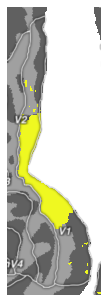

In [33]:
plot_V1_mask('02',np.concatenate([cmaskL[1],cmaskR[1]]),'left',full_fig)

Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)


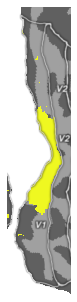

In [34]:
plot_V1_mask('02',np.concatenate([cmaskL[1],cmaskR[1]]),'right',full_fig)

There are 1377 V1 positions indicated by the vertices in this mask. For each of these, we need to compute a distance matrix.

In [37]:
cmaskL[0].shape
cmaskR[0].shape

(1327,)

Function for recovering subject surfaces from database

In [38]:
def get_subject_surfaces(sub,surf):
    surfs = [cortex.polyutils.Surface(*d)
    for d in cortex.db.get_surf(sub, surf)]
    return surfs

In [39]:
surfs=get_subject_surfaces('02','fiducial')

Function for recovering geodesic distances of a subset of vertices.

In [44]:
def get_geodesic_distance_array(surfs,verts,hem,save,outname):
    if hem=='left':
        surf=surfs[0]
    elif hem=='right':
        surf=surfs[1]
       

    dists=list()
    for vert in verts:
        dists.append(surf.geodesic_distance(vert))
    distarr=np.array(dists,dtype='float32')
    
    if save==1:
        dill_save(distarr,outname)
    
    return distarr

In [45]:
#fdistarrL=get_geodesic_distance_array(surfs,cmaskL[0],'left',1,os.path.join('/Volumes/BAHAMUT/OUTPUT/CF','v1distsL_32.pkl'))
#fdistarrR=get_geodesic_distance_array(surfs,cmaskR[0],'right',1,os.path.join('/Volumes/BAHAMUT/OUTPUT/CF','v1distsR_32.pkl'))

In [46]:
fdistarrL=None
fdistarrR=None

fdistarrL=load(os.path.join('/Volumes/BAHAMUT/OUTPUT/CF','v1distsL_32.pkl'))
fdistarrR=load(os.path.join('/Volumes/BAHAMUT/OUTPUT/CF','v1distsR_32.pkl'))


We now have a numpy array, with a distance matrix for each of the V1 vertices.

In [48]:
fdistarrL.shape

(1377, 163842)

Plot the first distance matrix.

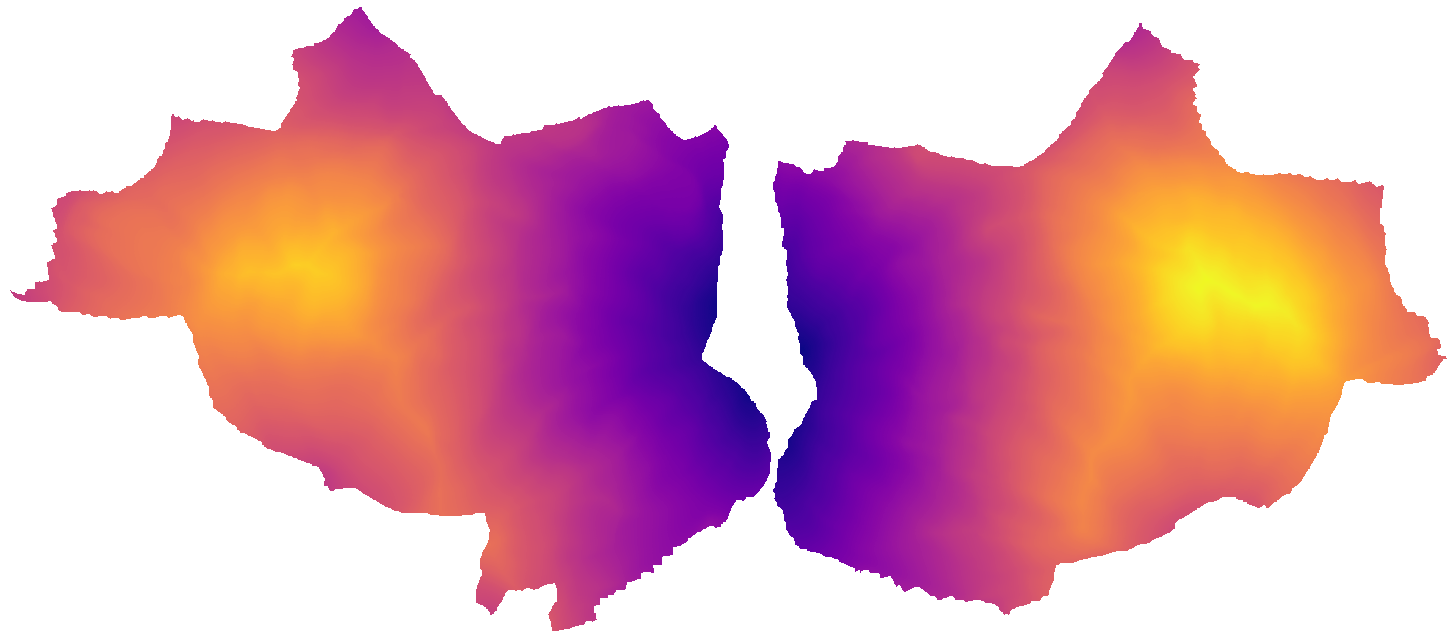

In [50]:
def lightplot(sub,dat,fig):
    light=cortex.Vertex(dat,subject=sub, vmin=np.nanmin(dat), vmax=np.nanmax(dat),cmap='plasma')
    mfig=cortex.quickshow(light,with_curvature=True,fig=fig,with_colorbar=False,with_rois=False)

import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

lightplot('02',np.concatenate([fdistarrL[0,:],fdistarrR[0,:]]),full_fig)

Now, we apply our gaussian function to the distance matrix to get gaussian patches. To get different size patches, we iterate through a list of sizes. Again, I dont go paralell here, since it seems to cause problems with big arrays like this.

In [55]:
nonv1indsL=np.array(sframeL['idx'][sframeL['ROI']!=1]).astype(int)
nonv1indsR=np.array(sframeR['idx'][sframeR['ROI']!=1]).astype(int)

In [53]:
sizes=[0.5,0.75,1,2,3,4,7,10,15,20]

In [54]:
def make_gaussian_patches(params,distarray,invmask):
    glist=list()
    for s in sizes:
        print(s)
        garray=gauss1D_cart(distarray,0,s)
        garray[:,[invmask]]=0
        glist.append(garray)
    return glist

In [56]:
garrayL=make_gaussian_patches(sizes,fdistarrL,nonv1indsL)
garrayR=make_gaussian_patches(sizes,fdistarrR,nonv1indsR)

0.5
0.75
1
2
3
4
7
10
15
20
0.5
0.75
1
2
3
4
7
10
15
20


Fo each size, we now have a gaussian centred on each vertex, stunted so it doesnt extend beyond the V1 boundary.

Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)


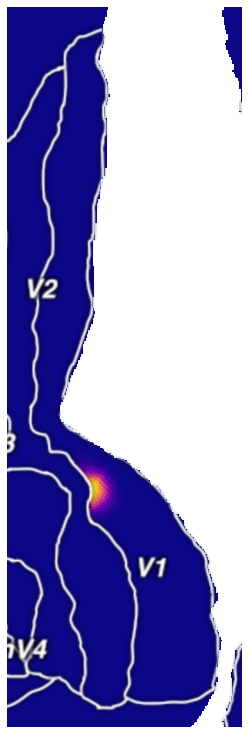

In [57]:
plot_V1_mask('02',garrayL[3][4,:],'left',full_fig)

Now we have these gaussians we can get the weighted signal within the gaussian, by dotting the data and the gaussian and dividing by the sum.

In [512]:
plt.plot(BIGDATAL2[:,34])

In [544]:
BIGDATAL2 = BIGDATAL +1 - np.min(BIGDATAL, axis=0)[None,:]

In [513]:
MYDAT=BIGDATAL2[:,34]

In [515]:
normdat=MYDAT/np.max(MYDAT)

In [524]:
0**0.2

0.0

In [555]:
sqdat=stats.zscore(BIGDATAL2[:,34]**0.1)
sqdat1=stats.zscore(BIGDATAL2[:,34]**1)
sqdat.astype(np.complex)

plt.plot(sqdat/np.max(sqdat))

In [554]:
sqdat=stats.zscore(BIGDATAL2[:,34])**0.1
sqdat1=stats.zscore(BIGDATAL2[:,34])**1
sqdat.astype(np.complex)

array([0.78158742+0.j, 0.89917046+0.j, 0.9331435 +0.j, 0.93415236+0.j,
       0.90993863+0.j,        nan+0.j,        nan+0.j,        nan+0.j,
              nan+0.j,        nan+0.j,        nan+0.j,        nan+0.j,
              nan+0.j,        nan+0.j,        nan+0.j,        nan+0.j,
              nan+0.j,        nan+0.j,        nan+0.j,        nan+0.j,
              nan+0.j,        nan+0.j,        nan+0.j,        nan+0.j,
              nan+0.j,        nan+0.j, 0.92981589+0.j, 1.02671838+0.j,
       1.08194113+0.j, 1.08879924+0.j, 1.04736626+0.j, 0.92821795+0.j,
              nan+0.j,        nan+0.j,        nan+0.j,        nan+0.j,
       0.87943494+0.j, 1.04911995+0.j, 1.08767128+0.j, 1.11938012+0.j,
       1.11088502+0.j, 1.0627054 +0.j,        nan+0.j,        nan+0.j,
              nan+0.j,        nan+0.j,        nan+0.j,        nan+0.j,
              nan+0.j,        nan+0.j,        nan+0.j,        nan+0.j,
              nan+0.j,        nan+0.j,        nan+0.j, 0.90954012+0.j,
      

In [543]:
plt.plot(sqdat)

In [528]:
-0.079**0.2

-0.6019014897798152

In [488]:
def cf_minimal_comp(ts_data,idx,garray,nl,nl2):
    
    pooled_dat=np.dot(ts_data**nl,garray[idx]**nl2)/sum(garray[idx]**nl2)
    
    zdat=stats.zscore(pooled_dat)
    norm_dat=zdat/np.max(zdat)
    return norm_dat

In [492]:
garrayL.shape

(10, 1377, 163842)

In [510]:
x=cf_minimal_comp(BIGDATAL2,119,garrayL[9],1,1)
y=cf_minimal_comp(BIGDATAL2,119,garrayL[9],0.0001,1)
plt.plot(x)
plt.plot(y,'r')

In [58]:
def cf_minimal(ts_data,idx,garray):
    pooled_dat=np.dot(ts_data,garray[idx])/sum(garray[idx])
    return pooled_dat

Now this is the bit that can take some time.

In [59]:
def get_cf_timecourses(garray,ts_data,procs):
    timecourses=list()
    for g in garray:
            timecourses.append(Parallel(n_jobs=procs,verbose=1,backend='multiprocessing')(delayed(cf_minimal)(ts_data,idx,g)  for idx in range(g.shape[0])))
    timecoursearray=np.array(timecourses,dtype='float32')
    return timecoursearray        

In [60]:
tc_arrayL=get_cf_timecourses(garrayL,BIGDATAL,15)

[Parallel(n_jobs=15)]: Using backend MultiprocessingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    3.6s
[Parallel(n_jobs=15)]: Done 170 tasks      | elapsed:    8.4s
[Parallel(n_jobs=15)]: Done 420 tasks      | elapsed:   16.1s
[Parallel(n_jobs=15)]: Done 770 tasks      | elapsed:   26.5s
[Parallel(n_jobs=15)]: Done 1220 tasks      | elapsed:   40.4s
[Parallel(n_jobs=15)]: Done 1377 out of 1377 | elapsed:   45.5s finished
[Parallel(n_jobs=15)]: Using backend MultiprocessingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    2.4s
[Parallel(n_jobs=15)]: Done 170 tasks      | elapsed:    7.7s
[Parallel(n_jobs=15)]: Done 420 tasks      | elapsed:   16.3s
[Parallel(n_jobs=15)]: Done 770 tasks      | elapsed:   30.1s
[Parallel(n_jobs=15)]: Done 1220 tasks      | elapsed:   45.5s
[Parallel(n_jobs=15)]: Done 1377 out of 1377 | elapsed:   50.5s finished
[Parallel(n_jobs=15)]: Using backend MultiprocessingBack

In [65]:
tc_arrayL.shape

(10, 1377, 120)

In [78]:
dill_save(tc_arrayL,os.path.join('/Volumes/BAHAMUT/OUTPUT/CF','tcL_32.pkl'))

In [79]:
tc_arrayR=get_cf_timecourses(garrayR,BIGDATAR,15)

[Parallel(n_jobs=15)]: Using backend MultiprocessingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    3.2s
[Parallel(n_jobs=15)]: Done 170 tasks      | elapsed:    7.5s
[Parallel(n_jobs=15)]: Done 420 tasks      | elapsed:   14.8s
[Parallel(n_jobs=15)]: Done 770 tasks      | elapsed:   25.7s
[Parallel(n_jobs=15)]: Done 1220 tasks      | elapsed:   39.9s
[Parallel(n_jobs=15)]: Done 1327 out of 1327 | elapsed:   43.3s finished
[Parallel(n_jobs=15)]: Using backend MultiprocessingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    2.5s
[Parallel(n_jobs=15)]: Done 170 tasks      | elapsed:    7.2s
[Parallel(n_jobs=15)]: Done 420 tasks      | elapsed:   15.5s
[Parallel(n_jobs=15)]: Done 770 tasks      | elapsed:   27.3s
[Parallel(n_jobs=15)]: Done 1220 tasks      | elapsed:   42.6s
[Parallel(n_jobs=15)]: Done 1327 out of 1327 | elapsed:   45.8s finished
[Parallel(n_jobs=15)]: Using backend MultiprocessingBack

Now we have a bunch of timeseries for each patch size centred on each V1 vertex. It makes sense to zscore these so that the intercept is removed from the equation.

In [80]:
dill_save(tc_arrayR,os.path.join('/Volumes/BAHAMUT/OUTPUT/CF','tcR_32.pkl'))

In [81]:
z_tc_arrayL=stats.zscore(tc_arrayL, axis=2)
z_tc_arrayR=stats.zscore(tc_arrayR, axis=2)

In [82]:
z_tc_array=np.hstack([z_tc_arrayL,z_tc_arrayR])

In [84]:
z_tc_array.shape

(10, 2704, 120)

Here, I also prepare the matrix of some prf parameters, so we can link the best fitting cf to the prf parameters.

In [ ]:
params=np.transpose(np.vstack((np.nan_to_num(np.array(sframeL['ang'])),np.nan_to_num(np.array(sframeL['ecc'])))))

Now we can find the best fitting patch by dotting the zscored timeseries and the zscored array of patches and finding the maximum dot product. I also convert this to R2.

In [86]:
def getminparams(ts_data,ind,zattarray):
    targdat=np.squeeze(stats.zscore(ts_data[:,ind]))
    dots=np.dot(zattarray,targdat)
    indices=np.array(np.unravel_index(dots.argmax(), dots.shape))
    
    
    r2 = (dots[indices[0],indices[1]]/120)**2
    cfparams=np.concatenate((np.array(indices), np.array(r2)), axis=None)
    
    
    return cfparams

In [87]:
cfsL=Parallel(n_jobs=10,verbose=1,backend='multiprocessing')(delayed(getminparams)(BIGDATAL,idx,z_tc_array)  for idx in nonv1indsL)

[Parallel(n_jobs=10)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 890 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done 2890 tasks      | elapsed:    5.7s
[Parallel(n_jobs=10)]: Done 5690 tasks      | elapsed:   10.7s
[Parallel(n_jobs=10)]: Done 9290 tasks      | elapsed:   17.0s
[Parallel(n_jobs=10)]: Done 13690 tasks      | elapsed:   24.5s
[Parallel(n_jobs=10)]: Done 18890 tasks      | elapsed:   33.6s
[Parallel(n_jobs=10)]: Done 24890 tasks      | elapsed:   44.2s
[Parallel(n_jobs=10)]: Done 31690 tasks      | elapsed:   57.1s
[Parallel(n_jobs=10)]: Done 39290 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 47690 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done 56890 tasks      | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done 66890 tasks      | elapsed:  2.0min
[Parallel(n_jobs=10)]: Done 77690 tasks      | elapsed:  2.4min
[Parallel(n_jobs=10)]: 

In [88]:
cfsR=Parallel(n_jobs=10,verbose=1,backend='multiprocessing')(delayed(getminparams)(BIGDATAR,idx,z_tc_array)  for idx in nonv1indsR)

[Parallel(n_jobs=10)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 890 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done 2890 tasks      | elapsed:    5.5s
[Parallel(n_jobs=10)]: Done 5690 tasks      | elapsed:   10.2s
[Parallel(n_jobs=10)]: Done 9290 tasks      | elapsed:   16.6s
[Parallel(n_jobs=10)]: Done 13690 tasks      | elapsed:   24.6s
[Parallel(n_jobs=10)]: Done 18890 tasks      | elapsed:   33.9s
[Parallel(n_jobs=10)]: Done 24890 tasks      | elapsed:   44.7s
[Parallel(n_jobs=10)]: Done 31690 tasks      | elapsed:   56.5s
[Parallel(n_jobs=10)]: Done 39290 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 47690 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done 56890 tasks      | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done 66890 tasks      | elapsed:  2.0min
[Parallel(n_jobs=10)]: Done 77690 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: 

Considering that everything outside of V1 is being fit, that didnt take very long at all. 

In [89]:
cfarrayL=np.array(cfsL)
cfarrayR=np.array(cfsR)

In [196]:
R2arrayL=np.zeros(163842)
idx1L=np.zeros(163842)
idx2L=np.zeros(163842)
R2arrayR=np.zeros(163842)
idx1R=np.zeros(163842)
idx2R=np.zeros(163842)

hemL=np.zeros(163842)
hemR=np.zeros(163842)

In [197]:
R2arrayL[nonv1indsL]=cfarrayL[:,2]
idx1L[nonv1indsL]=cfarrayL[:,0]
idx2L[nonv1indsL]=cfarrayL[:,1]

R2arrayR[nonv1indsR]=cfarrayR[:,2]
idx1R[nonv1indsR]=cfarrayR[:,0]
idx2R[nonv1indsR]=cfarrayR[:,1]

In [158]:
hemL=np.copy(idx2L.astype(int))
hemR=np.copy(idx2R.astype(int))

In [159]:
hemL=np.where(hemL>=1377, 2, 1)

In [160]:
hemR=np.where(hemR>=1377, 2, 1)

array([173,  75,   2, ..., 506,   2, 406])

In [94]:
R2array=np.concatenate([R2arrayL,R2arrayR])

In [96]:
light=cortex.Vertex(R2array,subject='02', vmin=np.nanmin(R2array), vmax=np.nanmax(R2array),cmap='plasma')

cortex.webshow(light)

Started server on port 55667


<JS: window.viewer>

Stopping server


In [161]:
hemarray=np.concatenate([hemL,hemR])

Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)


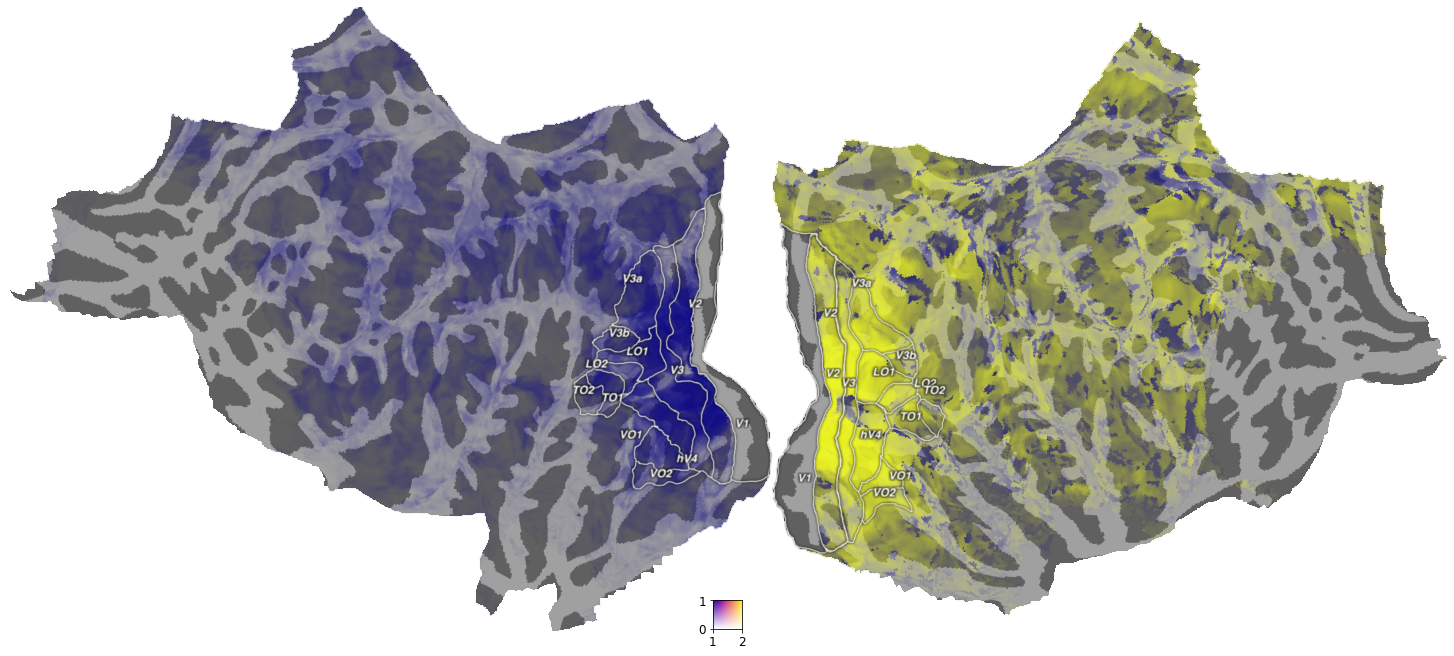

In [163]:
def alphaplot(sub,dat,R2,vmin,vmax,thresh,fig):
    light=cortex.Vertex2D(dat,R2,subject=sub, vmin=vmin, vmax=vmax,vmin2=thresh,vmax2=1,cmap='plasma_alpha')
    mfig=cortex.quickshow(light,with_curvature=True,fig=fig)
    return mfig
R2p=alphaplot('02',hemarray,R2array,1,2,0,full_fig)

Returned is an array. The first two columns are the indices of the best fitting gaussian (first column is cf size, second column is cf vertex). The last column is the R2. Now plot the cf model fits.

Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)


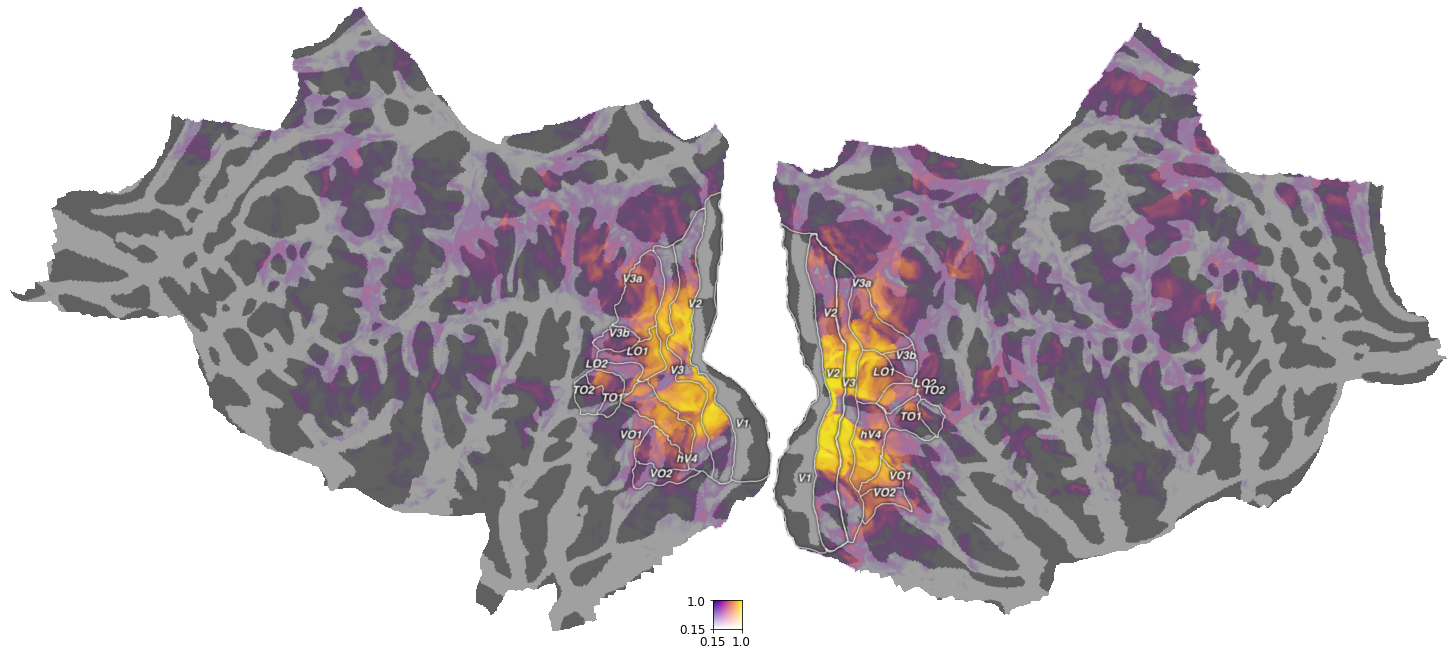

In [164]:
R2p=alphaplot('02',R2array,R2array,.15,1,.15,full_fig)

In [166]:
len(sizes)

10

In [167]:
sarrayL=np.zeros(163842,dtype=np.float64)
sarrayL[nonv1indsL]=cfarrayL[:,0]
sarrayR=np.zeros(163842,dtype=np.float64)
sarrayR[nonv1indsR]=cfarrayR[:,0]


for s in range(len(sizes)):    
    sarrayL=np.where(sarrayL==s, sizes[s], sarrayL)
    sarrayR=np.where(sarrayR==s, sizes[s], sarrayR)

In [168]:
sarray=np.concatenate([sarrayL,sarrayR])

Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)


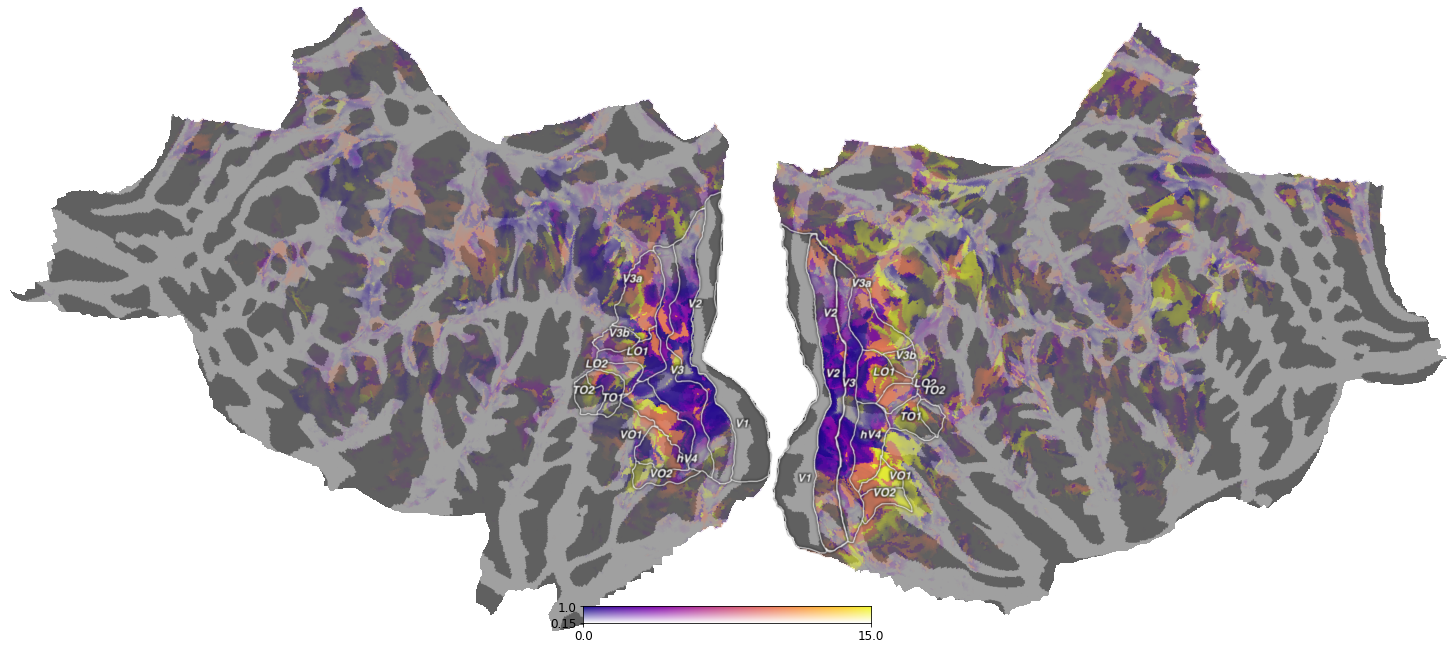

In [172]:
sp=alphaplot('02',sarray,R2array,0,15,.15,full_fig)

In [357]:
flat_path='/Volumes/BAHAMUT/OUTPUT/FULL/FLATMAPS/CF'

In [359]:
sp.savefig(os.path.join(flat_path,'sigma'+'_flat.png'), dpi=300, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches=None, pad_inches=0.1,
    frameon=None)

Convert the size indices to the sizes they actually correspond to. 

In [183]:
garrayL=np.array(garrayL)
garrayR=np.array(garrayR)

single click: button=1, x=2098, y=730, xdata=64.014597, ydata=-61.337944
(2933, 614)
  (0, 307828)	1.0
143986


In [188]:
garray=np.hstack([garrayL,garrayR])

In [355]:
import matplotlib
%matplotlib qt

matplotlib.use('Qt5Agg',warn=False, force=True)

fig, ax = plt.subplots(figsize=full_figsize)
import cortex as cx

dat=sarray
sub='02'
thresh=.15

R2=R2array

light=cortex.Vertex2D(dat,R2,subject=sub, vmin=np.nanmin(dat), vmax=np.nanmax(dat),vmin2=thresh,vmax2=1,cmap='plasma_alpha')


cx.quickshow(light, with_rois=True, with_curvature=True,fig=ax, with_colorbar=True)

flatmap_height = 2048
mask, extents = cx.quickflat.utils.get_flatmask(sub, height=flatmap_height)
vc = cx.quickflat.utils._make_vertex_cache(subject, height=flatmap_height)

mask_index = np.zeros(mask.shape)
mask_index[mask] = np.arange(mask.sum())
    

def draw_vertex_plots(vertex,hem):
    
    fig2, ax2 = plt.subplots()
    fig3, ax3 = plt.subplots()    
    
    ax2.clear()
    ax2.axhline(0, color='black', lw=0.25)
    if hem =='l':
        
        ax2.plot(stats.zscore(BIGDATAL[:,vertex]),'r')
        
        ax2.plot(z_tc_array[int(idx1L[vertex]),int(idx2L[vertex]),:],'b')
        
        #ax2.plot(np.array(longframe[longframe['idx']==vertex]['pred'])[0:119])
        #ax2.plot(np.array(longframe[longframe['idx']==vertex]['data'])[0:119])        
        #prf = generate_og_receptive_field(np.array(df[df['idx']==vertex]['X'])[0],np.array(df[df['idx']==vertex]['Y'])[0],
        #np.array(df[df['idx']==vertex]['sigma'])[0],stimulus.deg_x,stimulus.deg_y)
        
        ax3.clear()
        plot_V1_mask('02',garray[int(idx1L[vertex])][int(idx2L[vertex])],'left',ax3)
        plt.draw()
        
    else:

        ax2.plot(stats.zscore(BIGDATAR[:,vertex]),'r')
        ax2.plot(z_tc_array[int(idx1R[vertex]),int(idx2R[vertex]),:],'b')
        
        ax3.clear()
        plot_V1_mask('02',np.concatenate([garray[int(idx1R[vertex])][int(idx2R[vertex])],garray[int(idx1R[vertex])][int(idx2R[vertex])]]),'right',ax3)
        plt.draw()

    
def onclick(event):
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))
    xmin, xmax = ax.get_xbound()
    ax_xrange = xmax-xmin
    ymin, ymax = ax.get_ybound()
    ax_yrange = ymax-ymin

    rel_x = int(mask.shape[0] * (event.xdata-xmin)/ax_xrange)
    rel_y = int(mask.shape[1] * (event.ydata-ymin)/ax_yrange)
    clicked_pixel = (rel_x, rel_y)
    
    if event.xdata<0:
        hem='l'
        clicked_vertex = vc[int(mask_index[clicked_pixel[0], clicked_pixel[1]])]
        vindex=clicked_vertex.indices[0]
    else:
        hem='r'
        clicked_vertex = vc[int(mask_index[clicked_pixel[0], clicked_pixel[1]])]
        vindex=clicked_vertex.indices[0]-163842
    
    print(clicked_pixel)
    print(clicked_vertex)
    print(vindex)
    draw_vertex_plots(vindex,hem)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
single click: button=1, x=1017, y=341, xdata=47.151207, ydata=-73.985486
(2820, 529)
  (0, 291804)	1.0
127962
Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)


Now,I can use the index of the best fitting cf to recover the prf parameters within the cf.

It is possible to do this with advanced indexing (i.e. using an array of indexes to index another array) but my computer runs out of memory when I do this. Therefore I just do everything in a big loop.

In [ ]:
def get_prf_params(garray,idxarray,paramarray,idx):
    prfparams=np.dot(garray[tuple(idxarray[idx,:])],paramarray)/sum(garray[tuple(idxarray[idx,:])])
    return prfparams

In [ ]:
prf=Parallel(n_jobs=20,verbose=1,backend='multiprocessing')(delayed(get_prf_params)(garray,idxarray,params,idx)  for idx in range(idxarray.shape[0]))

In [ ]:
prf_arr=np.array(prf)

In [ ]:
angL=np.zeros(163842,dtype=np.float64)
angL[nonv1inds]=prf_arr[:,0]
angL[angL==0]=np.nan
ap=alphaplot('02',angL,R2arrayL,0,180,.15,full_fig)


ap.savefig(os.path.join(flat_path,'ang'+'_flat.png'), dpi=300, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches=None, pad_inches=0.1,
    frameon=None)

In [ ]:
eccL=np.zeros(163842,dtype=np.float64)
eccL[nonv1inds]=prf_arr[:,1]
eccL[eccL==0]=np.nan
ep=alphaplot('02',eccL,R2arrayL,0,8,.15,full_fig)


ep.savefig(os.path.join(flat_path,'ecc'+'_flat.png'), dpi=300, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches=None, pad_inches=0.1,
    frameon=None)

## Nonlinear Stuff

"First pass; I think you’d have to not z-score time courses but do everything in % signal change, and fit not using a dot product but with a GLM that incorporates an intercept."

As far as I can determine, All I should have to do is use a power transformation to change the gaussian rf model. For instance to the power of 1 is no transformation and to the power of <1 is a compressive cf.

Let's take my mid-sized gaussian fields (4 mm)

In [ ]:
garray.shape

In [ ]:
testfields=np.copy(garray[4,:,:])

And apply 5 different power transformations to them.

In [ ]:
nonlinearities=[1,0.2,0.1,0.05,0.01]

In [ ]:
css_testfields=list()
for nl in nonlinearities:
    print(nl)
    css_testfields.append(np.power(testfields,nl))   

Plot the linear model weightings against those of the most compressive model.

In [ ]:
plt.plot(css_testfields[0][0,:],css_testfields[4][0,:],'*')
plt.plot(css_testfields[0][0,:],css_testfields[3][0,:],'*')
plt.plot(css_testfields[0][0,:],css_testfields[2][0,:],'*')
plt.plot(css_testfields[0][0,:],css_testfields[1][0,:],'*')
plt.plot(css_testfields[0][0,:],css_testfields[0][0,:],'*')

The behavior is that a signal with a low weighting for the linear model is given a higher weighting in the compressive model. In other words, smaller amouts of overlap between the stimulus and the cf give rise to larger responses.

In [ ]:
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
ax0 = plt.subplot(gs[0])
plot_V1_mask('02',css_testfields[0][4,:],'left',ax0)
ax1 = plt.subplot(gs[1])
plot_V1_mask('02',css_testfields[3][4,:],'left',ax1)

Now we have these compressive fields, we can dot them with our data to see the different ways in which they respond.

In [ ]:
def get_cf_timecourses(garray,ts_data,procs):
    timecourses=list()
    for g in garray:
            timecourses.append(Parallel(n_jobs=procs,verbose=1,backend='multiprocessing')(delayed(cf_minimal)(ts_data,idx,g)  for idx in range(g.shape[0])))
    timecoursearray=np.array(timecourses)
    return timecoursearray    

In [ ]:
css_tc_array=get_cf_timecourses(css_testfields,BIGDATAL,15)

In [ ]:
css_tc_array.shape

In [ ]:
plt.plot(css_tc_array[0,4,:])
plt.plot(css_tc_array[4,4,:],'r')

In [ ]:
def fitter(EV,DV):
    regressor = LinearRegression()
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(EV, DV)
    r2=r_value**2
    return intercept,slope, r2

If we have to fit linear models to all of these combinations (i.e. we cant simply take the dot product), I would like to see what this involves. In other words, for each vertex, what number of combinations we will need to fit.

In [ ]:
import itertools

For instance, with 5 nonlinearities, 8 cf sizes and 1377 v1 vertices, this implies fitting 55,080 models for each vertex.

In [ ]:
paramlist=list(itertools.product(cmask[0], sizes,nonlinearities))

In [ ]:
len(paramlist)

In turn, we need to multiply this by the number of vertices there are to fit.

In [ ]:
nonv1inds.shape[0]*len(paramlist)

That's a big number.

In [ ]:
test=np.copy(garray)

In [ ]:
garray.shape

In [ ]:
from scipy.stats import linregress

In [ ]:
tc_array.shape

new_arr = tc_array.reshape(-1, tc_array.shape[-1])

In [ ]:
new_arr.shape[0]

In [ ]:
def fitter(dat,ind,tarray):
    results=Parallel(n_jobs=20,verbose=1,backend='multiprocessing')(delayed(linregress)(tarray[idx],dat[:,ind])  for idx in range(tarray.shape[0]))
    return results 

In [ ]:
var=fitter(BIGDATAL,2,new_arr)

In other words, I can test 24 different parameter combinations in 1.6 seconds.

In [ ]:
varray.shape

In [ ]:
plt.plot(BIGDATAL[:,1])

In [247]:
mydat=np.copy(BIGDATAL[:,34])

In [ ]:
plt.plot(mydat)

In [ ]:
cmpdat=mydat**0.1

In [ ]:
plt.plot(cmpdat)

In [ ]:
plt.plot(mydat)

In [ ]:
cmpdat=mydat**0.5

In [ ]:
0.1**0.1

In [204]:
plt.plot((mydat+1-np.min(mydat))**1/np.max((mydat+1-np.min(mydat))**1))
plt.plot((mydat+1-np.min(mydat))**0.5/np.max((mydat+1-np.min(mydat))**0.5))
plt.plot((mydat+1-np.min(mydat))**0.3/np.max((mydat+1-np.min(mydat))**0.3))
plt.plot((mydat+1-np.min(mydat))**0.1/np.max((mydat+1-np.min(mydat))**0.1))
plt.plot((mydat+1-np.min(mydat))**0.05/np.max((mydat+1-np.min(mydat))**0.05))

In [225]:
plt.plot((mydat-np.mean(mydat[0:12]))/np.mean(mydat[0:12]))

In [343]:
mydat=z_tc_array[0][0]

In [331]:
def compress(dat,nl):
    nzdat=(dat+1-np.min(dat))**nl
    zdat=stats.zscore(nzdat)
    
    sdat=nzdat/np.max(nzdat)
    dmsdat=(sdat-np.mean(sdat))/np.mean(sdat)
    
    return sdat

In [332]:
h=compress(mydat,1)

plt.plot(h)

h2=compress(mydat,0.5)
plt.plot(h2)

h3=compress(mydat,0.1)
plt.plot(h3)

h4=compress(mydat,0.01)
plt.plot(h4)


In [354]:
nzdat=(mydat+100-np.min(mydat))

plt.plot(stats.zscore(nzdat**1),stats.zscore(nzdat**0.01))

In [270]:
plt.plot(response,mydat)

In [ ]:
mydat_orig=mydat
mydat_orig_b=(mydat_orig+1-np.min(mydat_orig))

mydat_orig_b **= 0.1

plt.plot(mydat_orig_b*49)


plt.plot(mydat)


In [ ]:
dat=mydat
plt.plot(dat)
cdat=dat-np.mean(dat[0:12])
plt.plot(cdat)
nzdat=(cdat+1-np.min(cdat))**0.3
plt.plot(nzdat)
dmsdat=nzdat-np.mean(nzdat)
plt.plot(dmsdat)
